In [177]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

Your Name and PRN:
- Name: ______________________
- PRN : ______________________
- Date: ______________________

# Deep Neural Network
## Assignment A05

## Tensor Flow
- Select number of layers
- Select node in each of the layers
- Choose activation function
- multi-class - Fashion MNIST dataset (all 60000 images)
- Implement one or more of following to achieve max accuracy.
    - L1/ L2 Regularization
    - Dropout
    - Batch Normalization
    - Early stopping
- Save model

In [178]:
###-----------------
### Import Libraries
###-----------------
import os
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix

In [179]:
###-----------------
### Global Variables
###-----------------
inpDir = os.path.join('..', '..', 'input')
outDir = '../output'
modelDir = '../models'
subDir = 'fashion_mnist'
altName = 'A04_fashion_vanila'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible results
tf.random.set_seed(RANDOM_STATE)

EPOCHS=100
BATCH_SIZE=32
TEST_SIZE=0.2
TRAIN_SIZE = int(18 * BATCH_SIZE)

ALPHA = 0.001
WEIGHT_DECAY = 0.001
PATIENCE = 20
LR_FACTOR = 0.1
LR_PATIENCE=5
MIN_LR = 1e-6

# parameters for Matplotlib
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'
         }

CMAP = 'brg' # plt.cm.Spectral

plt.rcParams.update(params)


In [180]:
def plot_graph(history):
    fig,ax = plt.subplots(1,2,figsize=(15,8))
    ax[0].plot(history.epoch,history.history['accuracy'],label='accuracy')
    ax[0].plot(history.epoch,history.history['val_accuracy'],label='val_accuracy')
    ax[0].set_title('Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    ax[1].plot(history.epoch,history.history['loss'],label='loss')
    ax[1].plot(history.epoch,history.history['val_loss'],label='val_loss')
    ax[1].set_title('Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('loss')
    ax[1].legend()

    plt.show()
    

## Load Fashion MNIST dataset

This guide uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc.) in a format identical to that of the articles of clothing you'll use here.

This guide uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

Here, 60,000 images are used to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow. Import and [load the Fashion MNIST data](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data) directly from TensorFlow:

In [181]:
# train_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_train.csv')
# test_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_test.csv')

train_df = pd.read_csv(r"D:\dnn_input\fashion_mnist\fashion-mnist_train.csv", header = 0)
test_df = pd.read_csv(r"D:\dnn_input\fashion_mnist\fashion-mnist_test.csv", header = 0)
test_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:

In [182]:
#class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
#               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

class_names = {0: 'T-shirt/top',1:'Trouser',2:'Pullover',3:'Dress',4:'Coat',
               5:'Sandal', 6: 'Shirt',7: 'Sneaker', 8:'Bag', 9: 'Ankle boot'}

In [183]:
X_train,y_train = train_df.drop("label",axis=1),train_df["label"]
X_test,y_test = test_df.drop("label",axis=1),test_df["label"]
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((60000, 784), (10000, 784), (60000,), (10000,))

## **Converting to Dataset**

In [184]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train,y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test,y_test))

In [185]:
train_ds =train_ds.shuffle(buffer_size = X_train.shape[0]).batch(BATCH_SIZE)
test_ds= test_ds.shuffle(buffer_size =X_test.shape[0]).batch(BATCH_SIZE)

In [186]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

C:\Users\dai\AppData\Local\Temp\ipykernel_24144\3705107632.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(2,4,str(row[0]), color="b", fontsize=14)
C:\Users\dai\AppData\Local\Temp\ipykernel_24144\3705107632.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(10,25,class_names[row[0]],color ="r",fontsize=10)


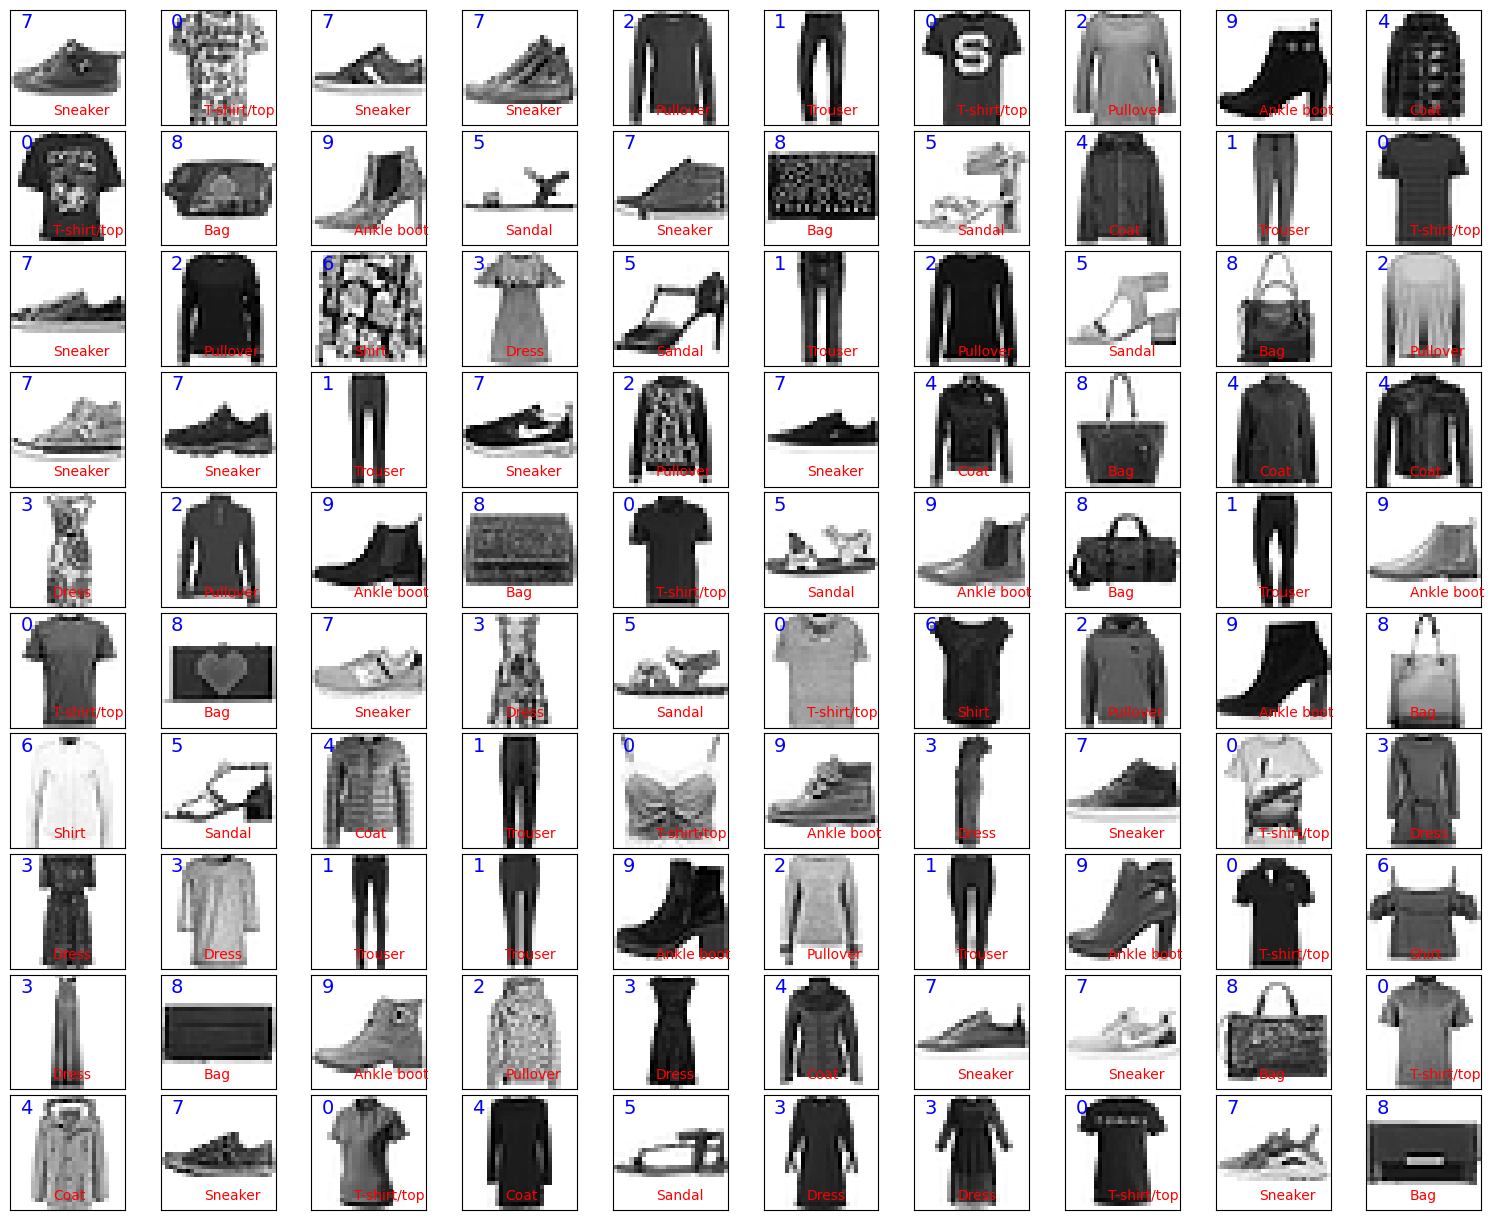

In [187]:
plot_df =train_df.sample(n=100)
fig = plt.figure(figsize =[15,12])
fig.subplots_adjust(left=0, right =1, bottom =0,top =1 ,hspace =0.05, wspace =0.05)

i=0
for _,row in plot_df.iterrows():
    i = i+1
    image =row.values[1:].reshape(28,28)
    ax =fig.add_subplot(10,10,(i),xticks=[],yticks=[])
    ax.imshow(image, cmap=plt.cm.binary, interpolation="nearest")
    ax.text(2,4,str(row[0]), color="b", fontsize=14)
    ax.text(10,25,class_names[row[0]],color ="r",fontsize=10)
plt.show()

In [188]:
(60000, 784)

(60000, 784)

In [189]:
for batch ,data in enumerate(train_ds.take(5)):
    print(batch,data)

0 (<tf.Tensor: shape=(32, 784), dtype=int64, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>, <tf.Tensor: shape=(32,), dtype=int64, numpy=
array([1, 7, 5, 9, 2, 4, 3, 2, 9, 8, 8, 0, 5, 9, 2, 6, 8, 2, 5, 8, 8, 8,
       9, 3, 3, 6, 0, 6, 9, 4, 8, 8])>)
1 (<tf.Tensor: shape=(32, 784), dtype=int64, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>, <tf.Tensor: shape=(32,), dtype=int64, numpy=
array([6, 8, 8, 0, 2, 7, 7, 0, 6, 4, 8, 3, 6, 3, 2, 2, 1, 7, 0, 5, 9, 7,
       9, 9, 9, 8, 0, 7, 5, 0, 1, 5])>)
2 (<tf.Tensor: shape=(32, 784), dtype=int64, numpy=
array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
      

In [190]:
X,y=next(iter(train_ds))
X[0]

<tf.Tensor: shape=(784,), dtype=int64, numpy=
array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,  

## Define Model

In [194]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(ALPHA)
kernel_reg = tf.keras.regularizers.L2(1e-4)
kernel_init = tf.keras.initializers.glorot_uniform(seed=RANDOM_STATE)

## Leaky relu, dropout

In [199]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(512,kernel_regularizer=tf.keras.regularizers.L2(1e-5)),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(256,kernel_regularizer=tf.keras.regularizers.L2(1e-4)),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.25),
    

    tf.keras.layers.Dense(128,activation='relu',kernel_regularizer=tf.keras.regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(64,kernel_regularizer=tf.keras.regularizers.L2(1e-4)),
    tf.keras.layers.LeakyReLU(0.01),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Dense(36,activation='relu'),
    tf.keras.layers.Dense(18,activation='relu'),

    tf.keras.layers.Dense(10),

])

model.compile(optimizer=tf.keras.optimizers.Adam(ALPHA),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [200]:
history = model.fit(train_ds,validation_data=test_ds,epochs=100)

Epoch 1/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.5364 - loss: 1.8934 - val_accuracy: 0.6955 - val_loss: 0.7793
Epoch 2/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.6965 - loss: 0.8225 - val_accuracy: 0.7663 - val_loss: 0.7111
Epoch 3/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.7403 - loss: 0.7495 - val_accuracy: 0.7862 - val_loss: 0.6335
Epoch 4/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.7442 - loss: 0.7455 - val_accuracy: 0.7788 - val_loss: 0.6587
Epoch 5/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.7678 - loss: 0.6943 - val_accuracy: 0.7943 - val_loss: 0.6326
Epoch 6/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.7648 - loss: 0.6975 - val_accuracy: 0.7284 - val_loss: 0.7401
Epoch 7/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.7633 - loss: 0.7008 - val_accuracy: 0.7016 - val_loss: 0.7894
Epoch 8/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.7711 -

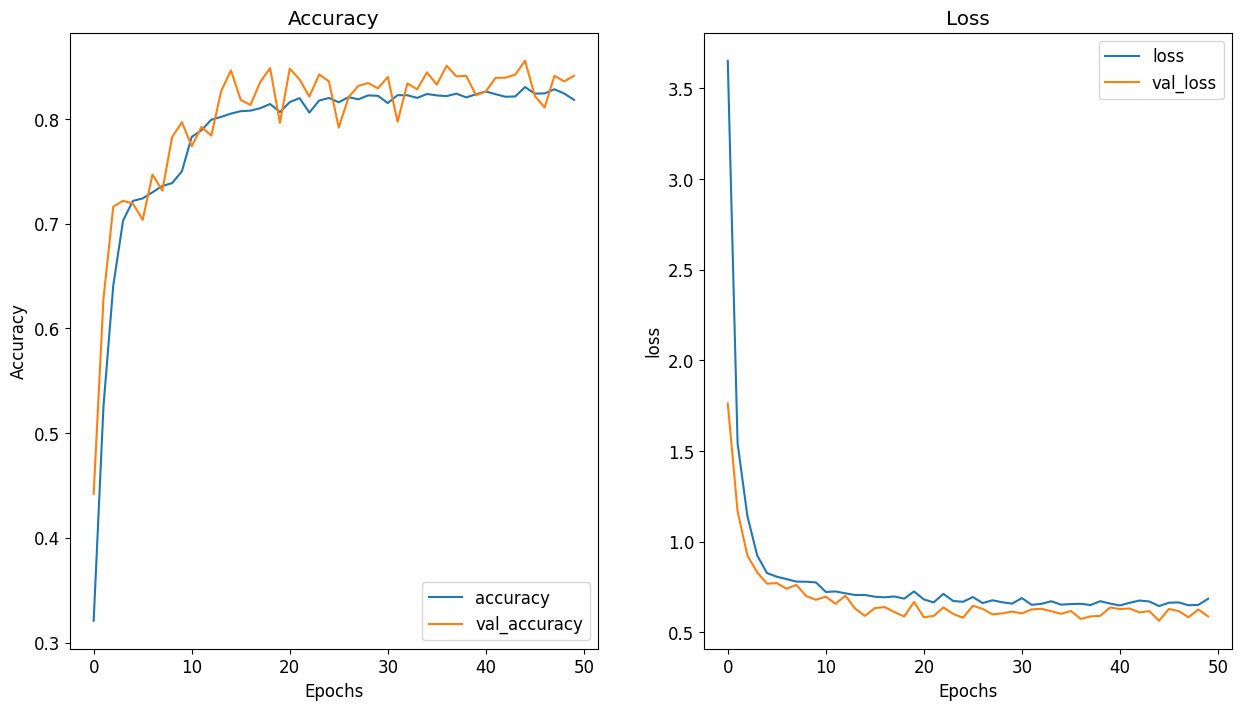

In [ ]:
fn_plot_tf_hist(history)

## Relu,dropout

In [201]:
# import keras


model = tf.keras.Sequential([
    tf.keras.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(512,activation='relu',kernel_regularizer=tf.keras.regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.6),

    tf.keras.layers.Dense(256,activation='relu',kernel_regularizer=tf.keras.regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(124,activation='relu',kernel_regularizer=tf.keras.regularizers.L2(1e-5)),

    tf.keras.layers.Dense(64),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(36,activation='relu'),

    tf.keras.layers.Dense(18,activation='relu'),
    tf.keras.layers.Dropout(0.1),
    
    tf.keras.layers.Dense(10),

])

model.compile(optimizer=tf.keras.optimizers.Adam(ALPHA),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [202]:
history = model.fit(train_ds,validation_data=test_ds,epochs=100)

Epoch 1/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.0983 - loss: 3.0939 - val_accuracy: 0.1000 - val_loss: 2.3131
Epoch 2/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.0970 - loss: 2.3136 - val_accuracy: 0.1000 - val_loss: 2.3129
Epoch 3/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.0980 - loss: 2.3155 - val_accuracy: 0.1000 - val_loss: 2.3126
Epoch 4/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.0979 - loss: 2.3125 - val_accuracy: 0.1000 - val_loss: 2.3120
Epoch 5/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.0979 - loss: 2.3253 - val_accuracy: 0.1000 - val_loss: 2.3115
Epoch 6/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.0974 - loss: 2.3110 - val_accuracy: 0.1000 - val_loss: 2.3100
Epoch 7/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.0979 - loss: 2.3092 - val_accuracy: 0.1000 - val_loss: 2.3080
Epoch 8/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.0979 -

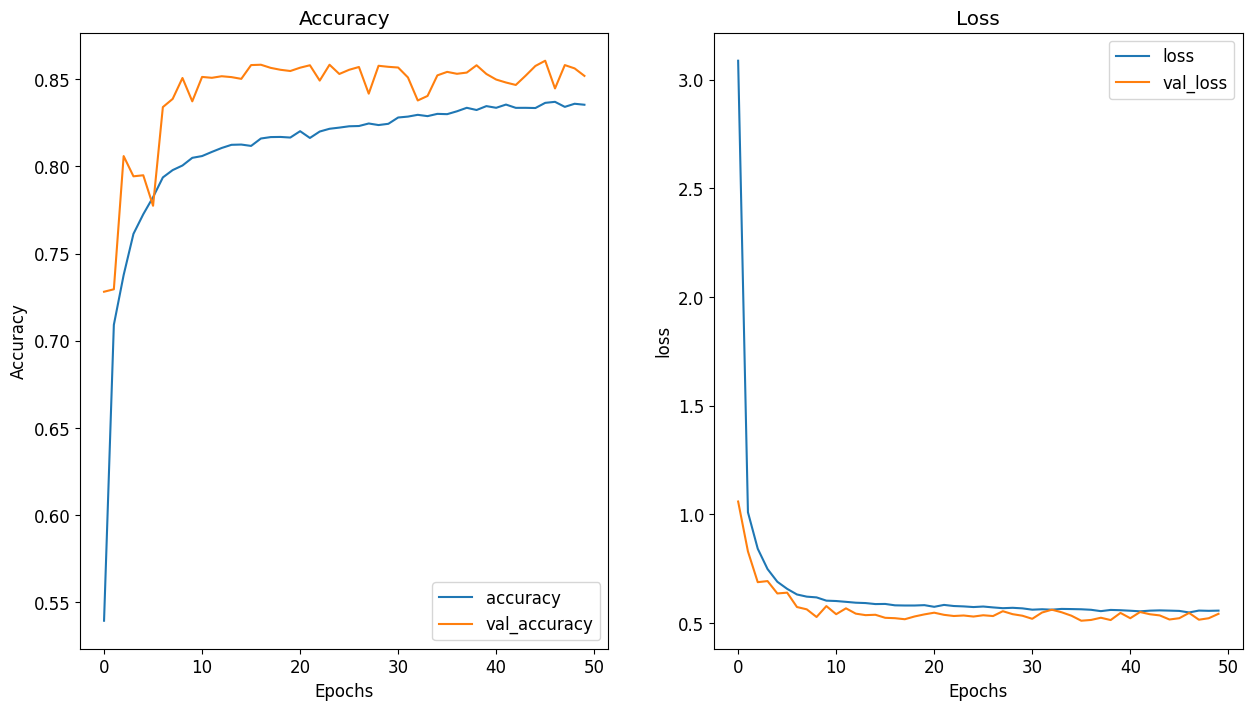

In [ ]:
fn_plot_tf_hist(history)

## Batch_Normalization

In [203]:

model = tf.keras.Sequential([
    tf.keras.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(512,kernel_regularizer=tf.keras.regularizers.L2(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.6),

    tf.keras.layers.Dense(256,kernel_regularizer=tf.keras.regularizers.L2(1e-5)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(124,kernel_regularizer=tf.keras.regularizers.L2(1e-5)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(64,kernel_regularizer=tf.keras.regularizers.L2(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(36,activation='relu'),
    tf.keras.layers.Dense(18,),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.1),


    tf.keras.layers.Dense(10),

])

model.compile(optimizer=tf.keras.optimizers.Adam(ALPHA),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [204]:
history = model.fit(train_ds,validation_data=test_ds,epochs=50)

Epoch 1/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - accuracy: 0.7456 - loss: 0.8422 - val_accuracy: 0.8282 - val_loss: 0.5544
Epoch 2/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.7994 - loss: 0.6651 - val_accuracy: 0.8469 - val_loss: 0.5188
Epoch 3/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.8102 - loss: 0.6307 - val_accuracy: 0.8481 - val_loss: 0.5117
Epoch 4/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.8129 - loss: 0.6170 - val_accuracy: 0.8494 - val_loss: 0.5048
Epoch 5/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.8219 - loss: 0.6069 - val_accuracy: 0.8446 - val_loss: 0.5180
Epoch 6/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.8218 - loss: 0.6021 - val_accuracy: 0.8584 - val_loss: 0.4899
Epoch 7/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.8243 - loss: 0.5984 - val_accuracy: 0.8420 - val_loss: 0.5309
Epoch 8/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.8261 -

AttributeError: 'History' object has no attribute 'columns'

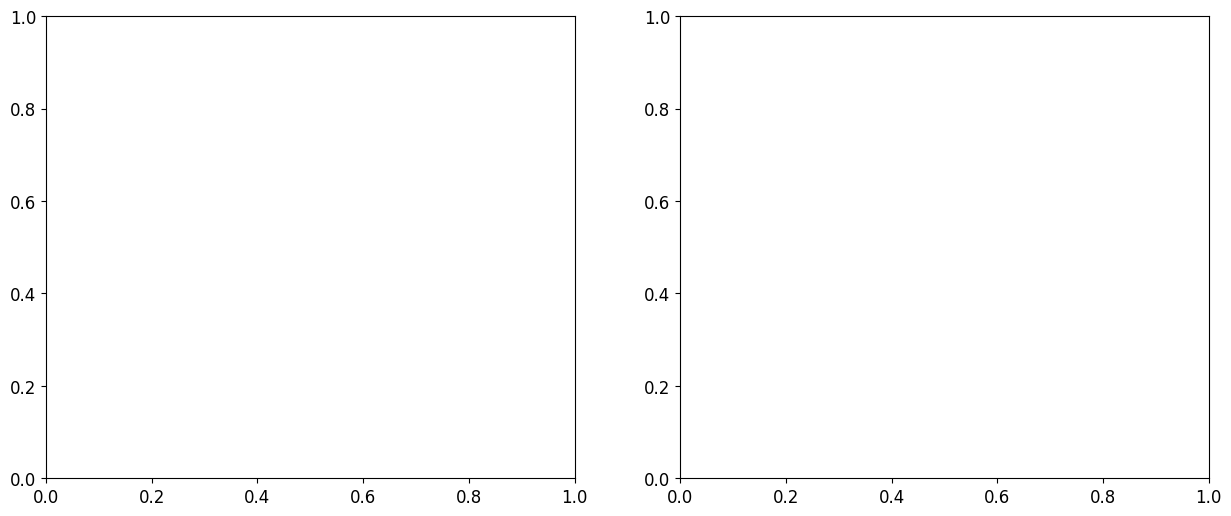

In [205]:
fn_plot_tf_hist(history)